# Satelittes position with skyfield
Notebook contains script that allows to calculate and plot satellites' positions in time based on TLE data.

## Import needed libs
* skyfield - astronomy computation package
* cartopy - geospatial data processing package
* matplotlib - data visualization package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from skyfield import api as sf
from skyfield.toposlib import Topos
import cartopy.crs as ccrs
import requests

## Load satellite TLE data from celestrak database

### Select satellite by name or ID

In [2]:
celestrak_base_url = 'https://celestrak.com/NORAD/elements/gp.php'
format_url_param = 'FORMAT=tle'
base_query_url = f'{celestrak_base_url}?{format_url_param}'

sat_selector_def = 'SENTINEL-2A'
sat_selector = input(f'satellite ID / name: (def: {sat_selector_def})') or sat_selector_def 
if sat_selector.isnumeric():
    response = requests.get(f'{base_query_url}&CATNR={sat_selector}')
else:
    response = requests.get(f'{base_query_url}&NAME={sat_selector}')

tle = response.text.splitlines()
print(f'TLE format:\n{tle[0]}\n{tle[1]}\n{tle[2]}' )
ts = sf.load.timescale()
satellite = sf.EarthSatellite(tle[1], tle[2], tle[0], ts)
print(f'Satellite object: {satellite}')

satellite ID / name: (def: SENTINEL-2A) 


TLE format:
SENTINEL-2A             
1 40697U 15028A   21051.51520195 -.00000220  00000+0 -67304-4 0  9998
2 40697  98.5694 128.1631 0001298  93.9316 266.2032 14.30814499295934
Satellite object: SENTINEL-2A catalog #40697 epoch 2021-02-20 12:21:53 UTC


### Display information from TLE

In [3]:
sat_number = int(tle[1][2:7])
sat_launch_year = 2000+int(tle[1][9:11])
tle_epoch_year = 2000+int(tle[1][18:20])
tle_epoch_day = float(tle[1][20:32])
sat_avg_rev_per_day = float(tle[2][52:63])
sat_rev_total = int(tle[2][63:-1])
print('Satellite details:\n' +
      f'name: {tle[0]}\n' +
      f'number: {sat_number}\n' +
      f'launch year: {sat_launch_year}\n' +
      f'avg. revolutions per day: {sat_avg_rev_per_day}\n' + 
      f'total revolutions since launch: {sat_rev_total}\n' +
      f'tle epoch year: {tle_epoch_year} day: {tle_epoch_day}\n')

Satellite details:
name: SENTINEL-2A             
number: 40697
launch year: 2015
avg. revolutions per day: 14.30814499
total revolutions since launch: 29593
tle epoch year: 2021 day: 51.51520195



### Check TLE creation date

In [4]:
time_now = ts.now()
days = time_now - satellite.epoch
print(f'{days} days away from epoch')

0.3753560737351678 days away from epoch


### Current position

In [5]:
position_now = satellite.at(time_now)
igrf_position = position_now.position
print(f'{satellite.name} geocentric ICRF position at {time_now.utc_strftime()} : {igrf_position.km} [km]')

SENTINEL-2A geocentric ICRF position at 2021-02-20 21:22:24 UTC : [ 3627.43152457 -3315.47669273  5210.34577523] [km]


In [6]:
topos_position = position_now.subpoint()
print(f'{satellite.name} topos position at {time_now.utc_strftime()} : {topos_position}')

SENTINEL-2A topos position at 2021-02-20 21:22:24 UTC : IERS2010 latitude +46.9306 N longitude -153.8691 E elevation 795521.6 m


### Next 24h positions

In [7]:
time_list = ts.utc(time_now.utc_datetime().year, time_now.utc_datetime().month, time_now.utc_datetime().day, time_now.utc_datetime().hour, time_now.utc_datetime().minute, range(0,24*60*60,10))

In [8]:
satellite_positions = [satellite.at(t) for t in time_list]
satellite_icrf_positions = [p.position for p in satellite_positions]
satellite_topos_positions = [p.subpoint() for p in satellite_positions]

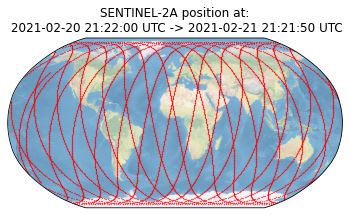

In [9]:
satellite_latitudes = [p.latitude.degrees for p in satellite_topos_positions]
satellite_longitudes = [p.longitude.degrees for p in satellite_topos_positions]
satellite_elevations = [p.elevation.km for p in satellite_topos_positions]

ax = plt.axes(projection=ccrs.Robinson())
ax.stock_img()
ax.plot(satellite_longitudes, satellite_latitudes, color='red', linestyle='', marker='.', markersize=0.5, transform=ccrs.PlateCarree())
ax.set_title(f'{satellite.name} position at:\n {time_list[0].utc_strftime()} -> {time_list[-1].utc_strftime()}')
plt.show()

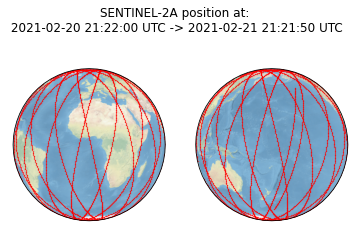

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.Orthographic(central_longitude=0))
ax1.stock_img()
ax1.plot(satellite_longitudes, satellite_latitudes, color='red', linestyle='', marker='.', markersize=0.5, transform=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.Orthographic(central_longitude=180))
ax2.stock_img()
ax2.plot(satellite_longitudes, satellite_latitudes, color='red', linestyle='', marker='.', markersize=0.5, transform=ccrs.PlateCarree())
fig.suptitle(f'{satellite.name} position at:\n {time_list[0].utc_strftime()} -> {time_list[-1].utc_strftime()}')
plt.show()